In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


## Getting the data

In [2]:
dir = '/kaggle/input/digit-recognizer/'
X_train = pd.read_csv(dir + 'train.csv')
X_test = pd.read_csv(dir + 'test.csv')

In [3]:
print('Train Data dimensions: ', X_train.shape)
print('Test Data dimensions: ', X_test.shape)

Train Data dimensions:  (42000, 785)
Test Data dimensions:  (28000, 784)


In [4]:
y = X_train.iloc[:,[0]] # Separate the labels from the rest of the training data
X = X_train.iloc[:,1:]

## Visualize the training data

In [5]:
def visualize_image(image_arr):
    image_mat = (np.array(image_arr)).reshape((28, 28))
    plt.imshow(image_mat, cmap='binary')
    plt.axis('off')

def visualize_multiple_images(image_idx_arr):
    figure = plt.figure(figsize=(12, 8))
    rows, cols, i = 10, 10, 1
    for idx in image_idx_arr:
        figure.add_subplot(rows, cols, i)
        visualize_image(X.iloc[idx,:])
        i = i + 1

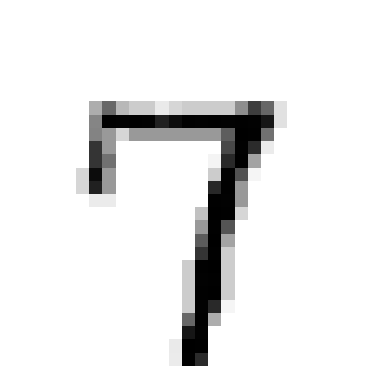

In [6]:
visualize_image(X.iloc[6,:])

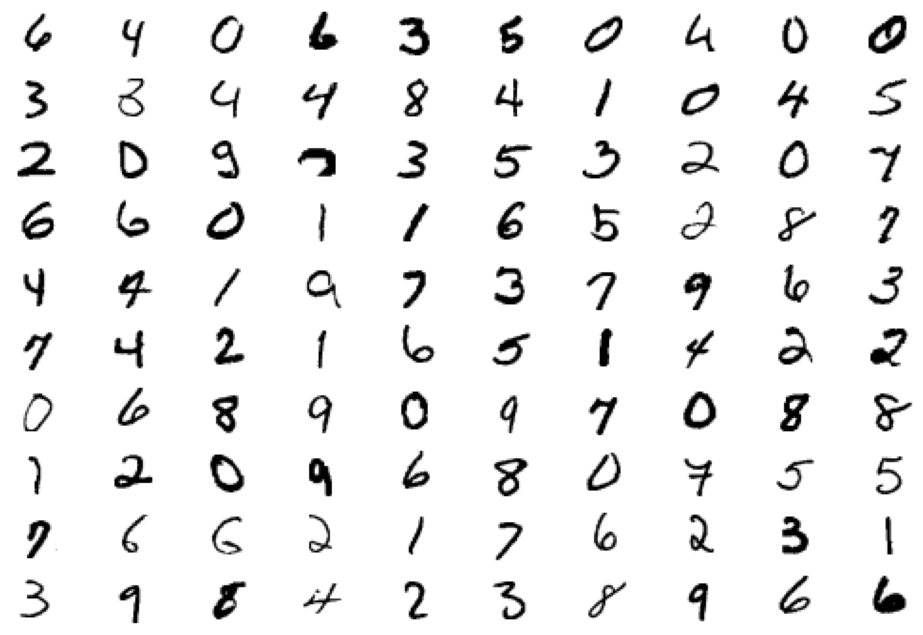

In [7]:
shuffled_indices = np.random.permutation(len(X))
visualize_multiple_images(shuffled_indices[:100])